In [37]:

import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns 
import warnings 
import scipy.stats as scs
import matplotlib.pyplot as plt

In [38]:
!pip install pandasql 

In [39]:
# Suppressing warning messages

warnings.filterwarnings('ignore')

In [40]:
# setting path to folders

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
scripts_dir = parent_dir+"/scripts"
data_dir = parent_dir+"/data"

sys.path.insert(1, scripts_dir)

In [41]:
# loading script

from data_summarizing_functions import DataSummarizer
from dashboard_viz import VizManager
from DistributionPlots import DistributionPlots as DisP

sumar = DataSummarizer()
viz = VizManager()
dis_p = DisP()

In [42]:
# loading data

clean_df = pd.read_csv(data_dir+"/SmartAd_clean_data.csv")

## Univariate Analysis

In [43]:
# Displaying unique values for each categorical variables.

sumar_df = sumar.summ_columns(clean_df)
sumar_df

,variables,missing_count,missing_percent_(%),data_type,unique_values
0,auction_id,0,0.0,object,1243
1,experiment,0,0.0,object,2
2,date,0,0.0,object,8
3,hour,0,0.0,int64,24
4,device_make,0,0.0,object,115
5,platform_os,0,0.0,int64,2
6,browser,0,0.0,object,8
7,yes,0,0.0,int64,2
8,no,0,0.0,int64,2


In [44]:
# exploring the identity of experiment groups.
aggr_df = sumar.find_agg(clean_df, ["experiment"], ["auction_id"], ["count"], ["count"])
aggr_df["percentage"] = (aggr_df["count"]/clean_df.shape[0])*100
aggr_df

,experiment,count,percentage
0,control,586,47.144006
1,exposed,657,52.855994


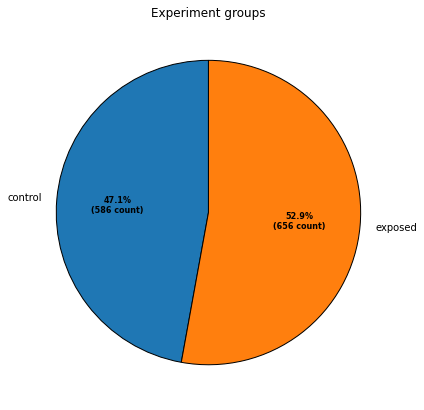

In [45]:
viz.plot_pie(aggr_df, ["experiment", "count"], "Experiment groups")

**Observation**
- experiment groups are almost equal in proportion
- the exposed group is slightly larger in number

In [46]:
# displaying top 10 devices used by users.

temp_df = sumar.find_agg(clean_df, ["device_make"], ["auction_id"], ["count"],["user_count"])
sumar.show_N_per_col(temp_df, "device_make", ["user_count"], 10)


Top 10 customers based on user_count

            device_make  user_count
13   Generic Smartphone         719
68     Samsung SM-G960F          45
66     Samsung SM-G950F          35
72     Samsung SM-G973F          22
43     Samsung SM-A202F          18
114              iPhone          18
64     Samsung SM-G930F          16
73     Samsung SM-G975F          15
47    Samsung SM-A405FN          14
42    Samsung SM-A105FN          13


**Observation**
- following generic device types, samsung models are the most dominant device type

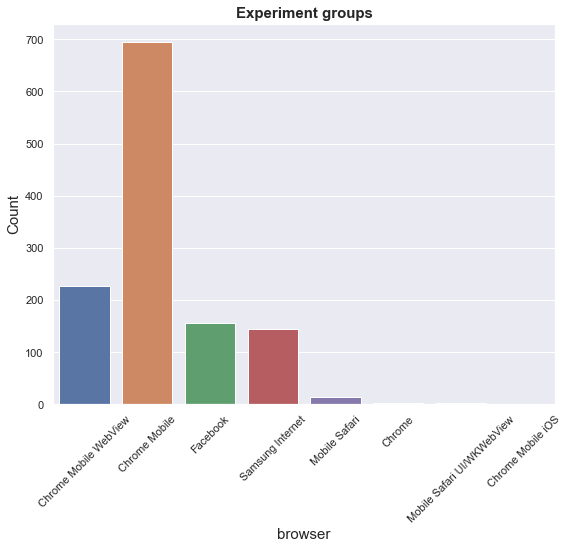

In [83]:
viz.plot_bar(clean_df,"browser", "None", "Experiment groups")

**Observation**
- Chrome browser is the most used type of browser.

Text(0.5, 1.0, 'Distribution of hour ')

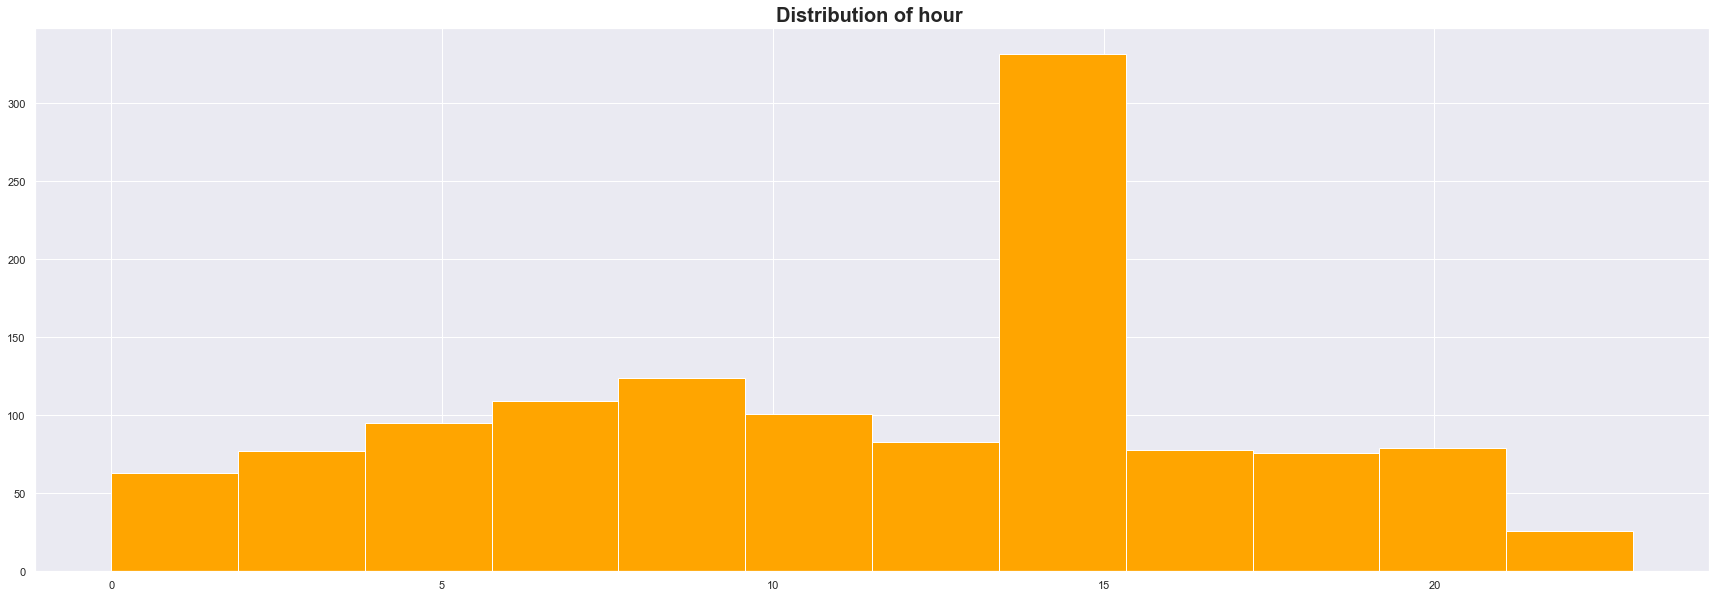

In [84]:
# plotting distribution of hour variable.


plt.hist(clean_df['hour'],bins=12, color='orange')
plt.title(f'Distribution of hour ', size=20, fontweight='bold')

**Observation**
- Users were more engaged on 15 hour.

2022-05-18 13:16:39.974 INFO    matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-05-18 13:16:39.980 INFO    matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'Distribution of Date ')

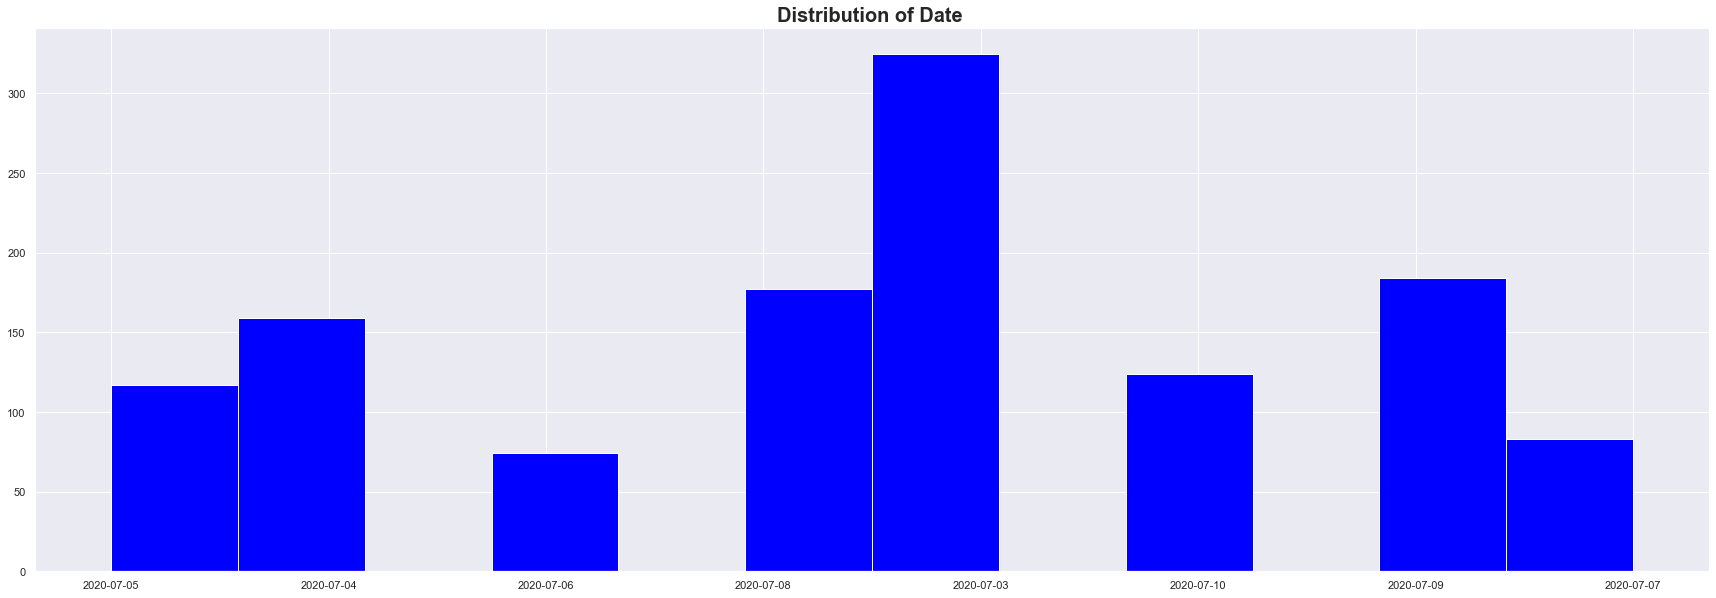

In [82]:

plt.hist(clean_df['date'],bins=12, color='blue')
plt.title(f'Distribution of Date ', size=20, fontweight='bold')

**Observation**
- Users were more engaged on 2020-07-03

## Bivariate Analysis

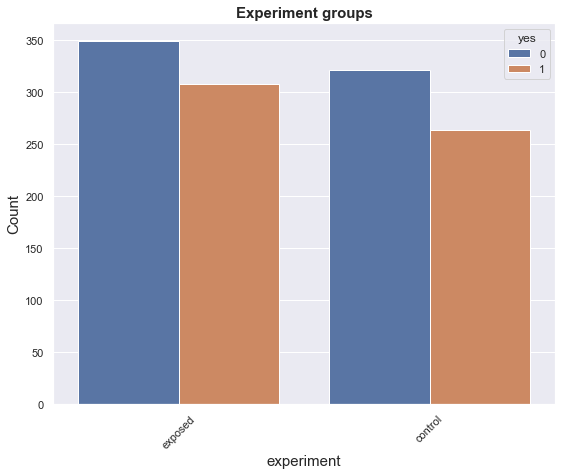

In [87]:
viz.plot_bar(clean_df,"experiment", "yes", "Experiment groups")

In [67]:
# plotting a correlation 
corr = clean_df.corr()
corr.style.background_gradient(cmap='coolwarm')
plt.savefig('corr.png')


<Figure size 2160x720 with 0 Axes>

In [29]:
# the aggregation of the data by experiment

ab_summary = clean_df.pivot_table(values = "yes", index = "experiment", aggfunc=np.sum)
ab_summary

,yes
experiment,
control,264
exposed,308


In [30]:
# calculating baseline conversion rate
ab_summary['total'] = clean_df.pivot_table(values="yes", index="experiment", aggfunc=lambda x: len(x))
ab_summary['rate'] = clean_df.pivot_table(values="yes", index="experiment")
ab_summary

,yes,total,rate
experiment,,,
control,264,586,0.450512
exposed,308,657,0.468798


In [31]:
# bcr extraction

bcr = ab_summary.loc["control", "rate"]
d_hat = 0.015 # setting the desired conversion rate of 1.5%
cr = ab_summary.loc["exposed", "rate"]
cr_dif = np.round(cr - bcr, 4)
print("there is a conversion rate difference of : ",cr_dif)

there is a conversion rate difference of :  0.0183


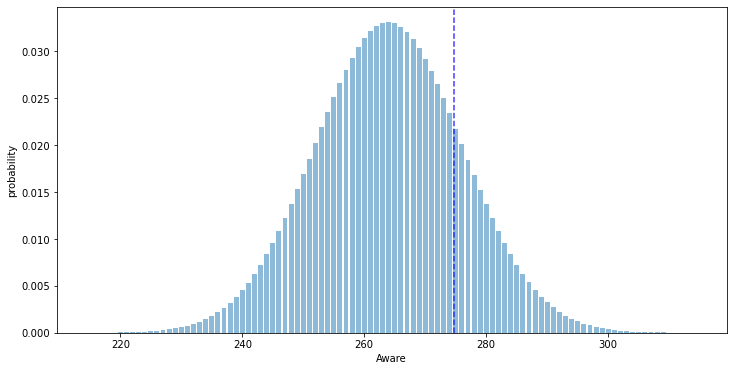

In [32]:
# drawing the distribution of the control group
c_aware = ab_summary.loc["control", "yes"]
c_total = ab_summary.loc["control", "total"]
c_cr = ab_summary.loc["control", "rate"]
e_cr = ab_summary.loc["exposed", "rate"]
dis_p.cont_distribution(c_aware, c_total, c_cr, e_cr)

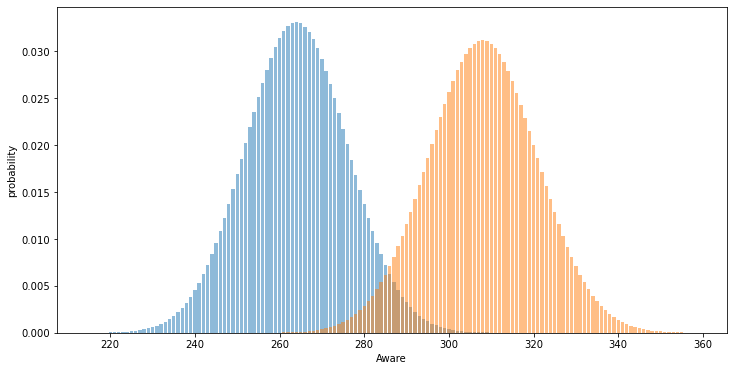

In [33]:
e_aware = ab_summary.loc["exposed", "yes"]
e_total = ab_summary.loc["exposed", "total"]
dis_p.cont_exp_distribution(c_aware, e_aware, c_total, e_total, c_cr, e_cr)

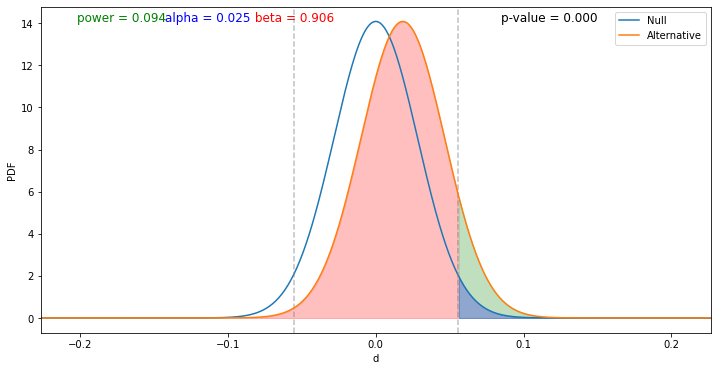

In [34]:
# showing the normal distribution of the the null hypothesis and the alternative hypothesis.

dis_p.null_alt_distribution(c_total, e_total, c_cr, e_cr)

In [35]:
# calculate the sample size needed for the specified power and confidence level


def get_sample_size(power, p1, p2, cl, max_n = 1000000):
    n = 1
    while n<=max_n:
        tmp_power = get_power(n, p1, p2, cl)
        if tmp_power >= power:
            return n
        else:
            n=n+1